Machine Learning models for obesity risk prediction

In [130]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import math
import sklearn as sk
import xgboost as xgb
from hmmlearn.hmm import GaussianHMM
import matplotlib.image as mpimg
from sklearn.metrics import classification_report

In [2]:
# Load data
data = pd.read_csv("Data_collection_and_cleaning/processed_data/csv_files/Processed_data.csv",
                   header= 0)

Descriptive analysis

In [3]:
data.head(2)

,subjid,sex,age_days,age_years,date_of_measurement,height_cm,weight_kg,bmi,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,763,2.089023,2015-11-13,87.0,13.2,17.439556,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1118,3.060980,2016-11-02,96.0,15.9,17.252604,1.30,Overweight


In [4]:
print(f"Number of rows: {data.shape[0]}, Number of columns: {data.shape[1]}")

Number of rows: 247663, Number of columns: 10


In [5]:
data.describe()

,age_days,age_years,height_cm,weight_kg,bmi,zbmi
count,247663.000000,247663.000000,247663.000000,247663.000000,247663.000000,247663.000000
mean,2302.077900,6.302875,117.018334,25.911639,17.422402,0.548033
std,1306.740792,3.577735,23.459458,15.057504,3.397402,1.316509
min,731.000000,2.001410,56.000000,4.750000,9.433962,-5.810000
25%,1129.000000,3.091097,97.000000,15.000000,15.231812,-0.340000
50%,2196.000000,6.012444,114.000000,20.400000,16.451348,0.450000
75%,3178.000000,8.701068,134.000000,32.500000,18.518263,1.360000
max,5478.000000,14.998255,202.000000,153.000000,48.836541,10.090000


In [6]:
# Check NA count
data.isna().sum()

subjid                 0
sex                    0
age_days               0
age_years              0
date_of_measurement    0
height_cm              0
weight_kg              0
bmi                    0
zbmi                   0
zbmi_type              0
dtype: int64

In [7]:
data.dtypes

subjid                  object
sex                     object
age_days                 int64
age_years              float64
date_of_measurement     object
height_cm              float64
weight_kg              float64
bmi                    float64
zbmi                   float64
zbmi_type               object
dtype: object

In [8]:
# Number of patients
len(data.subjid.unique())

62798

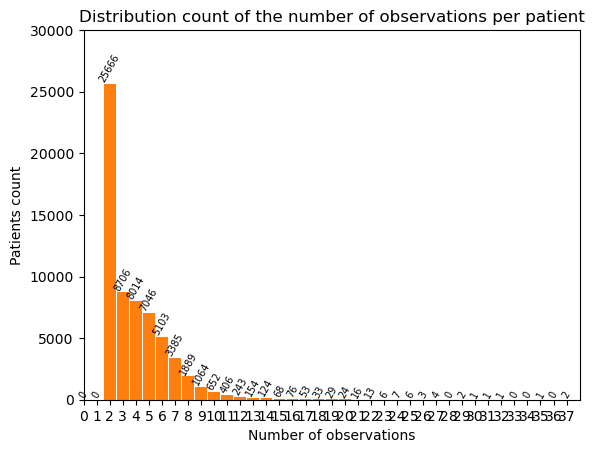

In [9]:
# Plot number of patients by number of obs
n_patients = data.value_counts("subjid")
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 30000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Distribution count of the number of observations per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Number of observations")

plt.show()

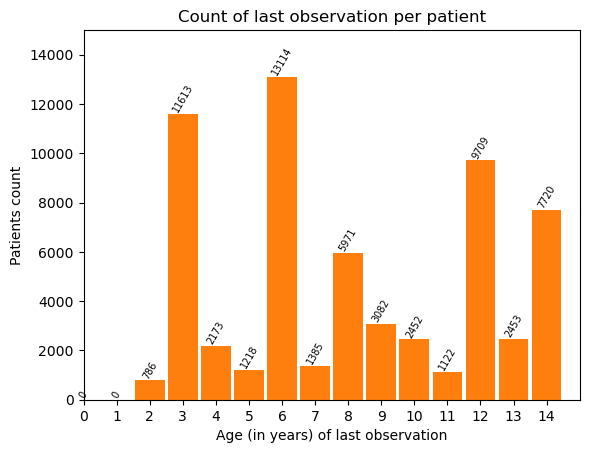

In [10]:
# Plot number of patients by age_years of obs
n_patients = data.groupby("subjid")["age_years"].max().apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 15000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of last observation per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Age (in years) of last observation")

plt.show()

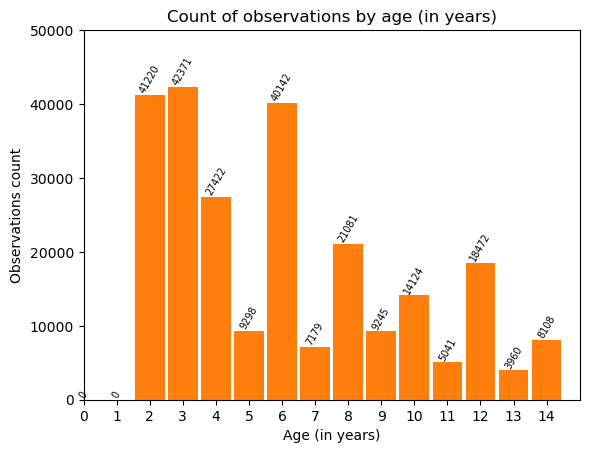

In [11]:
# Plot observations by age_years
n_patients = data.age_years.apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 50000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of observations by age (in years)")
ax.set_ylabel("Observations count")
ax.set_xlabel("Age (in years)")

plt.show()

We will consider the following models for comparison: LSTM, GRU, Random Forest, XGBoost, HMM, and Gaussian Processes.

To train the models reshaping of our data is needed so we have one row per patient.

In [4]:
# Modify data
data["age_years"] = data["age_years"].apply(math.trunc)
data = data.loc[:, ["subjid", "sex", "age_years", "zbmi", "zbmi_type"]]
data.head(10)

,subjid,sex,age_years,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,3,1.30,Overweight
2,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,4,0.73,Normal_weight
3,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,6,1.52,Overweight
4,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,8,1.70,Overweight
5,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,4,0.79,Normal_weight
6,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,6,0.66,Normal_weight
7,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,8,0.23,Normal_weight
8,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,10,0.59,Normal_weight
9,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,12,0.58,Normal_weight


Analysis of the zbmi trayectories by age:

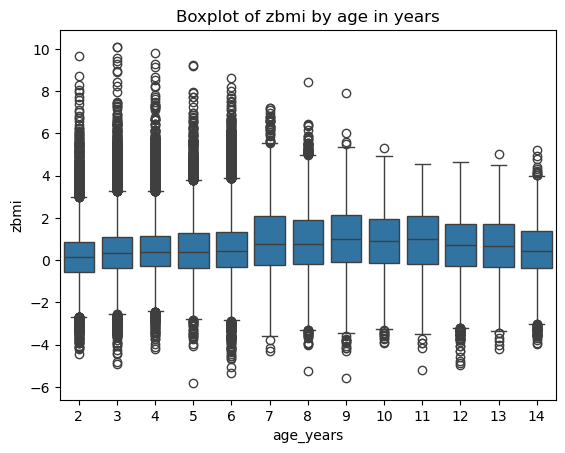

In [4]:
# Plot zbmi by age_years
sns.boxplot(x='age_years', y='zbmi', data=data)
plt.title("Boxplot of zbmi by age in years")
plt.show()

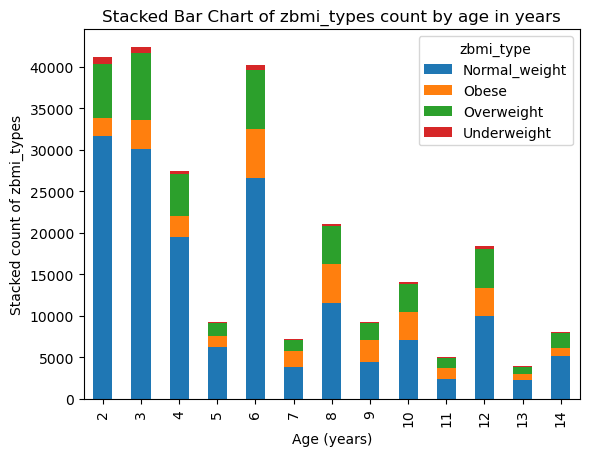

In [10]:
# Bar chart of each zbmi_type by age
stacked_counts = data.groupby(['age_years', 'zbmi_type']).size().unstack(fill_value=0)
stacked_counts.plot(kind='bar', stacked=True)

plt.xlabel('Age (years)')
plt.ylabel('Stacked count of zbmi_types')
plt.title('Stacked Bar Chart of zbmi_types count by age in years')

# Show the plot
plt.show()

In [5]:
# Reshape data
zbmi_pivoted = data.pivot_table(index=["subjid", "sex"], columns="age_years", values="zbmi", aggfunc="mean")
zbmi_types_pivoted = data.pivot_table(index=["subjid", "sex"], columns="age_years", values="zbmi_type", aggfunc="first")

# Combine multilevel columns
zbmi_pivoted.columns = [f"zbmi_{col}" for col in zbmi_pivoted.columns]
zbmi_types_pivoted.columns = [f"zbmi_type_{col}" for col in zbmi_types_pivoted.columns]

# Combine data
pivot_data = pd.merge(zbmi_pivoted, zbmi_types_pivoted, on=["subjid", "sex"], how="inner")
pivot_data.reset_index(inplace=True)

pivot_data.head(5)

,subjid,sex,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,...,zbmi_type_5,zbmi_type_6,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1.24,1.30,0.73,NaN,1.52,NaN,1.70,NaN,...,NaN,Overweight,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,NaN,NaN,0.79,NaN,0.66,NaN,0.23,NaN,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,NaN,NaN,1.43,NaN,1.77,NaN,2.92,3.13,...,NaN,Overweight,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight
3,++FtKeESpTd0npbWZhKbKwz5udKbtTTDS02C,Female,0.77,1.06,NaN,1.3,NaN,NaN,NaN,NaN,...,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,++H+79RWVcymBKRpLj7G0Qz5udOavTvIR0uC,Male,NaN,0.63,NaN,NaN,0.83,NaN,NaN,NaN,...,NaN,Normal_weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Add ages again
names = ["age_" + str(x) for x in range(2, 15, 1)]
ages = [x for x in range(2, 15, 1)]
age_dict = dict(zip(names, ages))

for agename, agevalue in age_dict.items():
    pivot_data[agename] = agevalue

# Reorder columns
age_cols = [col for col in pivot_data.columns if 'age' in col]

pivot_data = pivot_data[["subjid", "sex"] + 
                        age_cols + 
                        [col for col in pivot_data.columns if col not in age_cols and col not in ["subjid", "sex"]]]


pivot_data.head(3)

,subjid,sex,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,...,zbmi_type_5,zbmi_type_6,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,2,3,4,5,6,7,8,9,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight


In [7]:
# Correct labels of zbmi_types
for i in range(2, 15, 1):
    typezbmi = f"zbmi_type_{i}"
    zbmi = f"zbmi_{i}"
    for index, row in pivot_data.iterrows():
        if i < 5:
            match row[zbmi]:
                case value if value < -2.0:
                    pivot_data.at[index, typezbmi] = "Underweight"
                case value if value >= -2.0 and value <= 2.0:
                    pivot_data.at[index, typezbmi] = "Normal_weight"
                case value if value > 2.0 and value <= 3.0:
                    pivot_data.at[index, typezbmi] = "Overweight"
                case value if value > 3.0:
                    pivot_data.at[index, typezbmi] = "Obese"
                case _:
                    pivot_data.at[index, typezbmi] = np.nan
        if i >= 5:
            match row[zbmi]:
                case value if value < -2.0:
                    pivot_data.at[index, typezbmi] = "Underweight"
                case value if value >= -2.0 and value <= 1.0:
                    pivot_data.at[index, typezbmi] = "Normal_weight"
                case value if value > 1.0 and value <= 2.0:
                    pivot_data.at[index, typezbmi] = "Overweight"
                case value if value > 2.0:
                    pivot_data.at[index, typezbmi] = "Obese"
                case _:
                    pivot_data.at[index, typezbmi] = np.nan

In [8]:
# Encode sex variable
from sklearn.preprocessing import OneHotEncoder
sex_encoder = OneHotEncoder(sparse_output=False)
sex_encoded = sex_encoder.fit_transform(pivot_data["sex"].values.reshape(-1, 1))
sex_encoded_df = pd.DataFrame(sex_encoded, columns= sex_encoder.get_feature_names_out(['sex']))
pivot_data = pd.concat([pivot_data, sex_encoded_df], axis=1)

In [9]:
pivot_data.head(3)

,subjid,sex,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,...,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14,sex_Female,sex_Male
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,2,3,4,5,6,7,8,9,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN,0.0,1.0
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,2,3,4,5,6,7,8,9,...,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight,0.0,1.0


In [10]:
# Check if the patient number is not affected
len(pivot_data)

62798

Data will be split between 67% train and 33% test, stratifying by sex and zbmi_type_14 label to ensure we
have some final data points in both train and test subsets. Some models need further preparation
after train-test split, so data will be prepared individually in order to maximize performance of
each model.

In [11]:
# Create a temporary column with combination of columns to stratify
pivot_data["stratify"] = pivot_data["sex"].astype(str) + "_" + pivot_data["zbmi_type_14"]
sex_column = pivot_data.pop("sex")

In [12]:
pivot_data.head(10)

,subjid,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,...,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14,sex_Female,sex_Male,stratify
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,2,3,4,5,6,7,8,9,10,...,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,2,3,4,5,6,7,8,9,10,...,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN,0.0,1.0,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,2,3,4,5,6,7,8,9,10,...,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
3,++FtKeESpTd0npbWZhKbKwz5udKbtTTDS02C,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN
4,++H+79RWVcymBKRpLj7G0Qz5udOavTvIR0uC,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN
5,++I9nc5fKbO/u4b1/2yTiQz5udKYvDzNTkGC,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN
6,++L0bHwVuddtTPbPle9/ggz5uNubsDnCSkyG,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,Overweight,NaN,NaN,1.0,0.0,NaN
7,++NsVGPHnkdWDpwjB16tQAz5udORsT7CR0GB,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,Obese,NaN,NaN,1.0,0.0,NaN
8,++PF9XmuTG6SFeJwR1ZiBAz5udKctT7OSk6A,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN
9,++RKhV3ihA/cUyWtQJ+BFQz5udKQsT3CS0GB,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN


In [13]:
# Change stratify NaN to Unknown
pivot_data["stratify"] = pivot_data["stratify"].fillna("Unknown")

In [14]:
zbmi_cols = [f'zbmi_{i}' for i in range(13, 1, -1)]
pivot_data['zbmi_14'] = pivot_data['zbmi_14'].fillna(pivot_data[zbmi_cols].bfill(axis=1).iloc[:, 0])

In [15]:
zbmi_cols.insert(0, 'zbmi_14')

In [16]:
pivot_data[zbmi_cols].head(10)

,zbmi_14,zbmi_13,zbmi_12,zbmi_11,zbmi_10,zbmi_9,zbmi_8,zbmi_7,zbmi_6,zbmi_5,zbmi_4,zbmi_3,zbmi_2
0,1.70,NaN,NaN,NaN,NaN,NaN,1.70,NaN,1.52,NaN,0.73,1.30,1.24
1,0.58,NaN,0.58,NaN,0.59,NaN,0.23,NaN,0.66,NaN,0.79,NaN,NaN
2,0.87,NaN,2.23,NaN,3.00,3.13,2.92,NaN,1.77,NaN,1.43,NaN,NaN
3,1.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30,NaN,1.06,0.77
4,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.83,NaN,NaN,0.63,NaN
5,1.92,NaN,NaN,NaN,NaN,NaN,NaN,1.92,NaN,NaN,NaN,1.55,NaN
6,1.37,NaN,1.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15
7,2.13,NaN,2.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,0.37,NaN
9,1.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.15,NaN,0.91,0.46


To test if the interpolated data and the real final data differ in results, we will create a reduced version of the data with only real values at the age of 14, hence two models of each algorithm will be created. 

In [17]:
# Create reduced dataset
pivot_data_reduced = pivot_data[pivot_data["stratify"] != "Unknown"].copy()
pivot_data_reduced.head(10)

,subjid,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,...,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14,sex_Female,sex_Male,stratify
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,2,3,4,5,6,7,8,9,10,...,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
10,++TMQDydqMEDVhkvMZorEAz5uNqfvTjPSUCE,2,3,4,5,6,7,8,9,10,...,NaN,NaN,Obese,NaN,Obese,NaN,Overweight,0.0,1.0,Male_Overweight
12,++UQyyx5zN8/2ROXp2NM8Qz5uNqfsjvKSUyE,2,3,4,5,6,7,8,9,10,...,Normal_weight,NaN,NaN,NaN,Normal_weight,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
15,++mGjCfP1+SKGhi6zda2xAz5uNqftjrKRkGD,2,3,4,5,6,7,8,9,10,...,Normal_weight,NaN,NaN,NaN,Overweight,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
16,++ti/Fbi47RVATZ6735MfQz5uNqdsD7KR02E,2,3,4,5,6,7,8,9,10,...,Overweight,NaN,Overweight,NaN,Normal_weight,NaN,Normal_weight,1.0,0.0,Female_Normal_weight
28,+/CJg9A4oAdUU6bEm6imfAz5uNqetj7JSU6H,2,3,4,5,6,7,8,9,10,...,Obese,NaN,NaN,NaN,Obese,NaN,Obese,0.0,1.0,Male_Obese
36,+/heju9v6y4V9nLPYaWVOQz5uNqesTXIR0+C,2,3,4,5,6,7,8,9,10,...,NaN,NaN,Overweight,NaN,Overweight,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
39,+/jbg4CGf7n7V0FNAfYWOAz5uNqftTjNTkyA,2,3,4,5,6,7,8,9,10,...,Normal_weight,NaN,NaN,NaN,Normal_weight,NaN,Normal_weight,1.0,0.0,Female_Normal_weight
51,+06aeVqt18DrW5Nbu+138Qz5uNqetj7MT06G,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,Obese,1.0,0.0,Female_Obese
55,+0EBI+ro95zfkfUlUsgn7wz5uNuZsTXPS0yE,2,3,4,5,6,7,8,9,10,...,Normal_weight,Normal_weight,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,0.0,1.0,Male_Normal_weight


In [18]:
pivot_data_reduced.shape

(7720, 43)

In [19]:
# Train-test split 67%-33%
y = pivot_data.pop("zbmi_14")

zbmis = pivot_data[[col for col in pivot_data.columns if '_type' not in col]]
pivot_data = pivot_data[[col for col in pivot_data.columns if '_type' not in col]]

xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(pivot_data.drop(columns=["age_14"]),
                                                                   y,
                                                                   test_size=0.33,
                                                                   random_state=42,
                                                                   stratify=pivot_data["stratify"])
stratify_column = pivot_data.pop("stratify")

In [20]:
# Train-test split 67%-33% pivot_data_reduced
reduced_y = pivot_data_reduced.pop("zbmi_14")

reduced_zbmis = pivot_data_reduced[[col for col in pivot_data_reduced.columns if '_type' not in col]]
pivot_data_reduced = pivot_data_reduced[[col for col in pivot_data_reduced.columns if '_type' not in col]]

reduced_xtrain, reduced_xtest, reduced_ytrain, reduced_ytest = sk.model_selection.train_test_split(pivot_data_reduced.drop(columns=["age_14"]),
                                                                   reduced_y,
                                                                   test_size=0.33,
                                                                   random_state=42,
                                                                   stratify=pivot_data_reduced["stratify"])
reduced_stratify_column = pivot_data_reduced.pop("stratify")

In [21]:
# Dataframe shapes
print(f"Xtrain: number of rows = {xtrain.shape[0]}, number of columns = {xtrain.shape[1]}")
print(f"Xtest: number of rows = {xtest.shape[0]}, number of columns = {xtest.shape[1]}")
print(f"Ytrain: number of rows = {ytrain.shape[0]}")
print(f"Ytest: number of rows = {ytest.shape[0]}")

Xtrain: number of rows = 42074, number of columns = 28
Xtest: number of rows = 20724, number of columns = 28
Ytrain: number of rows = 42074
Ytest: number of rows = 20724


In [22]:
xtrain.head(5)

,subjid,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,...,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,zbmi_12,zbmi_13,sex_Female,sex_Male,stratify
25106,EiAE5NYdj56uflkYvwqsTQz5udObszrPSECD,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
36361,MIS7h3GhTWgHCOpWeprnEgz5uNuftD7ISkCH,2,3,4,5,6,7,8,9,10,...,NaN,1.09,NaN,NaN,NaN,1.6600,NaN,1.0,0.0,Unknown
8380,3XG+IdpcK3uf23C+klJUxAz5udKevT3NSUuH,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,1.25,0.3925,NaN,0.0,1.0,Unknown
6827,2Wc8jnptHIashrHcGwZw2wz5uNqdtz/PSkCD,2,3,4,5,6,7,8,9,10,...,NaN,-0.29,NaN,-0.24,NaN,0.3600,NaN,1.0,0.0,Female_Normal_weight
52767,dYFpTzPT7ovK6WoYj+CVJAz5udKYtzXNTkuD,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown


In [23]:
# Reduced dataframe shapes
print(f"Reduced Xtrain: number of rows = {reduced_xtrain.shape[0]}, number of columns = {reduced_xtrain.shape[1]}")
print(f"Reduced Xtest: number of rows = {reduced_xtest.shape[0]}, number of columns = {reduced_xtest.shape[1]}")
print(f"Reduced Ytrain: number of rows = {reduced_ytrain.shape[0]}")
print(f"Reduced Ytest: number of rows = {reduced_ytest.shape[0]}")

Reduced Xtrain: number of rows = 5172, number of columns = 28
Reduced Xtest: number of rows = 2548, number of columns = 28
Reduced Ytrain: number of rows = 5172
Reduced Ytest: number of rows = 2548


LSTM model

The Long Short Term Memory models need a 3D array as input with the form of samples, time_steps, features. In our case, the samples are the rows, the time_steps are our 12 measurements (zbmi from ages 2 through 13) and features are the value at each time_step, and both sex columns since they are one-hot-encoded.

We will also make two LSTM models: one where the weight is calculated with a specific function and the second one using the Sequential approach.

In [24]:
def lstm_preprocess(df, measure_cols, sex_cols, real_col):
    LSTM_measures = df[measure_cols].values.reshape(-1, len(measure_cols), 1)
    LSTM_sex = df[sex_cols].values
    sex_repeated = np.repeat(LSTM_sex[:, np.newaxis, :], len(measure_cols), axis=1)
    is_real_value = df[real_col].apply(lambda x: 0 if x == "Unknown" else 1).values
    is_real_value = is_real_value.reshape(-1, 1, 1)
    is_real_value = np.repeat(is_real_value, len(measure_cols), axis=1)
    LSTM_combined = np.concatenate([LSTM_measures, sex_repeated, is_real_value], axis=2)
    return LSTM_combined

In [25]:
LSTM_measure_cols = [f"zbmi_{i}" for i in range(2, 14)]
LSTM_xtrain = lstm_preprocess(xtrain, LSTM_measure_cols, ["sex_Female", "sex_Male"], "stratify")
LSTM_xtest = lstm_preprocess(xtest, LSTM_measure_cols, ["sex_Female", "sex_Male"], "stratify")

In [26]:
print(f"LSTM train shape: {LSTM_xtrain.shape}, LSTM test shape: {LSTM_xtest.shape}")

LSTM train shape: (42074, 12, 4), LSTM test shape: (20724, 12, 4)


In [27]:
# LSTM Model
class LSTM_model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.lstm = tf.keras.layers.LSTM(64, return_sequences = True)
        self.lstm2 = tf.keras.layers.LSTM(32, return_sequences = False)
        self.dense32 = tf.keras.layers.Dense(32, activation = "relu")
        self.dense1 = tf.keras.layers.Dense(1, activation = "linear")
        self.mae = tf.keras.metrics.MeanAbsoluteError()
    
    def call(self, inputs, training=False):
        x = self.lstm(inputs)
        x = self.lstm2(x)
        x = self.dense32(x)
        return self.dense1(x)
    
    def compute_weights(self, inputs):
        values = inputs[:, :, 0]
        is_not_nan = ~tf.math.is_nan(values)
        reversed_mask = tf.reverse(is_not_nan, axis=[1])
        last_real_index = tf.argmax(tf.cast(reversed_mask, tf.float32), axis=1)
        last_real_index = 12 - 1 - tf.cast(last_real_index, tf.float32)
        max_distance = tf.constant(12.0)
        recency_weight = 1.0 - (last_real_index / max_distance)
        y_is_real = inputs[:, -1, -1]
        y_is_real = tf.cast(y_is_real, tf.float32)
        return recency_weight * y_is_real

    def compute_real_mae(self, y_true, y_pred, is_real):
        is_real = tf.cast(is_real, tf.float32)
        abs_error = tf.abs(y_true - y_pred)
        masked_error = abs_error * is_real[:, tf.newaxis]

        total_error = tf.reduce_sum(masked_error)
        count = tf.reduce_sum(is_real)
        return total_error / (count + 1e-6)

    def train_step(self, data):
        inputs, y_true = data
        y_is_real = inputs[:, -1, -1]

        with tf.GradientTape() as tape:
            y_pred = self(inputs, training = True)
            weights = self.compute_weights(inputs)
            loss = tf.reduce_mean(tf.abs(y_true - y_pred) * weights[:, tf.newaxis])
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.mae.update_state(y_true, y_pred)
        real_mae = self.compute_real_mae(y_true, y_pred, y_is_real)
        
        return {"loss": loss, "mae": self.mae.result(), "real_mae": real_mae}

In [28]:
# Instantiate, compile and fit model
lstm_model = LSTM_model()
lstm_model.compile(optimizer = "adam")
LSTM_history = lstm_model.fit(LSTM_xtrain, ytrain, epochs = 10, batch_size = 32)

Epoch 1/10
1315/1315 [==============================] - 20s 10ms/step - loss: 0.0246 - mae: 1.0802 - real_mae: 0.9869
Epoch 2/10
1315/1315 [==============================] - 13s 10ms/step - loss: 0.0243 - mae: 1.0409 - real_mae: 0.9820
Epoch 3/10
1315/1315 [==============================] - 13s 10ms/step - loss: 0.0242 - mae: 1.0333 - real_mae: 0.9783
Epoch 4/10
1315/1315 [==============================] - 13s 10ms/step - loss: 0.0242 - mae: 1.0430 - real_mae: 0.9744
Epoch 5/10
1315/1315 [==============================] - 13s 10ms/step - loss: 0.0242 - mae: 1.0340 - real_mae: 0.9671
Epoch 6/10
1315/1315 [==============================] - 13s 10ms/step - loss: 0.0242 - mae: 1.0324 - real_mae: 0.9704
Epoch 7/10
1315/1315 [==============================] - 13s 10ms/step - loss: 0.0242 - mae: 1.0428 - real_mae: 0.9788
Epoch 8/10
1315/1315 [==============================] - 13s 10ms/step - loss: 0.0242 - mae: 1.0362 - real_mae: 0.9805
Epoch 9/10
1315/1315 [==============================] - 

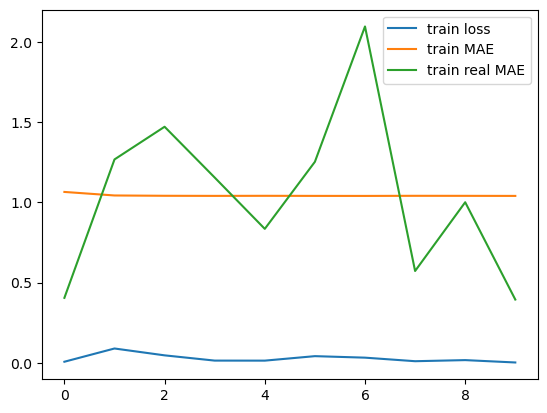

In [29]:
plt.plot(LSTM_history.history['loss'], label='train loss')
plt.plot(LSTM_history.history['mae'], label='train MAE')
plt.plot(LSTM_history.history['real_mae'], label='train real MAE')
plt.legend()
plt.show()

Sequential LSTM

In [35]:
Seq_lstm_xtrain = np.nan_to_num(LSTM_xtrain, nan=999.0)
Seq_lstm_xtest = np.nan_to_num(LSTM_xtest, nan=999.0)
Seq_lstm_model = tf.keras.models.Sequential()
Seq_lstm_model.add(tf.keras.layers.Input(shape=(12, 4)))
Seq_lstm_model.add(tf.keras.layers.Masking(mask_value=999.0))
Seq_lstm_model.add(tf.keras.layers.LSTM(64))
Seq_lstm_model.add(tf.keras.layers.Dense(1, activation='linear'))
Seq_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [36]:
seq_LSTM_model = Seq_lstm_model.fit(Seq_lstm_xtrain, ytrain, epochs=10, batch_size=32, validation_split = 0.2)

Epoch 1/10
1052/1052 [==============================] - 17s 10ms/step - loss: 0.3168 - mae: 0.3100 - val_loss: 0.0616 - val_mae: 0.1193
Epoch 2/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0590 - mae: 0.1162 - val_loss: 0.0538 - val_mae: 0.1092
Epoch 3/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0529 - mae: 0.1040 - val_loss: 0.0505 - val_mae: 0.0955
Epoch 4/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0501 - mae: 0.0967 - val_loss: 0.0524 - val_mae: 0.1186
Epoch 5/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0489 - mae: 0.0944 - val_loss: 0.0484 - val_mae: 0.0901
Epoch 6/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0481 - mae: 0.0936 - val_loss: 0.0479 - val_mae: 0.0872
Epoch 7/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0479 - mae: 0.0924 - val_loss: 0.0482 - val_mae: 0.0900
Epoch 8/10
1052/1052 [==============================] - 8s 8

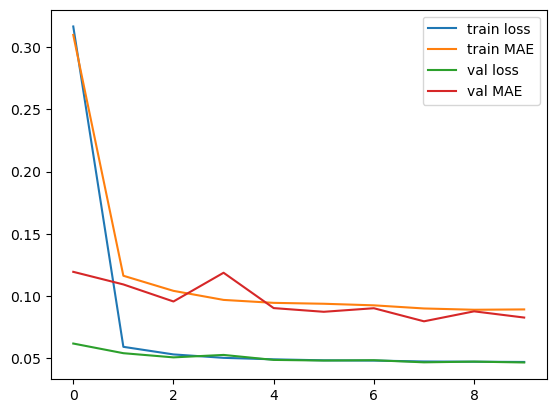

In [37]:
plt.plot(seq_LSTM_model.history['loss'], label='train loss')
plt.plot(seq_LSTM_model.history['mae'], label='train MAE')
plt.plot(seq_LSTM_model.history['val_loss'], label='val loss')
plt.plot(seq_LSTM_model.history['val_mae'], label='val MAE')
plt.legend()
plt.show()

GRU

In [38]:
GRU_xtrain = np.nan_to_num(LSTM_xtrain, nan=999.0)
GRU_xtest = np.nan_to_num(LSTM_xtest, nan=999.0)

In [39]:
gru_model = tf.keras.models.Sequential()
gru_model.add(tf.keras.layers.Input(shape=(12, 4)))
gru_model.add(tf.keras.layers.Masking(mask_value=999.0))
gru_model.add(tf.keras.layers.GRU(64))
gru_model.add(tf.keras.layers.Dense(1, activation='linear'))
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [40]:
GRU_model = gru_model.fit(GRU_xtrain, ytrain, epochs=10, batch_size=32, validation_split = 0.2)

Epoch 1/10
1052/1052 [==============================] - 17s 10ms/step - loss: 0.2132 - mae: 0.2210 - val_loss: 0.0534 - val_mae: 0.0944
Epoch 2/10
1052/1052 [==============================] - 8s 7ms/step - loss: 0.0535 - mae: 0.1025 - val_loss: 0.0514 - val_mae: 0.1114
Epoch 3/10
1052/1052 [==============================] - 8s 7ms/step - loss: 0.0501 - mae: 0.0959 - val_loss: 0.0472 - val_mae: 0.0823
Epoch 4/10
1052/1052 [==============================] - 8s 7ms/step - loss: 0.0481 - mae: 0.0904 - val_loss: 0.0492 - val_mae: 0.1094
Epoch 5/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0477 - mae: 0.0901 - val_loss: 0.0470 - val_mae: 0.0969
Epoch 6/10
1052/1052 [==============================] - 8s 7ms/step - loss: 0.0470 - mae: 0.0888 - val_loss: 0.0504 - val_mae: 0.1068
Epoch 7/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0465 - mae: 0.0864 - val_loss: 0.0470 - val_mae: 0.0934
Epoch 8/10
1052/1052 [==============================] - 8s 8

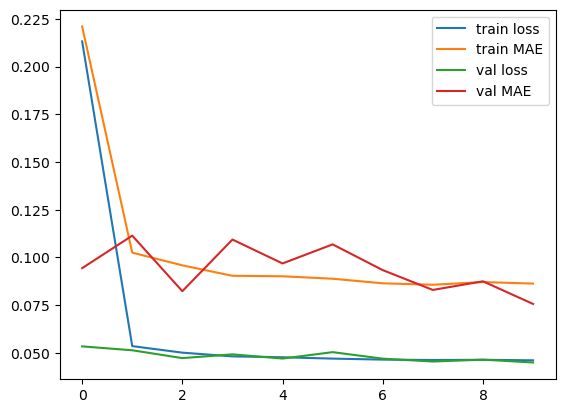

In [41]:
plt.plot(GRU_model.history['loss'], label='train loss')
plt.plot(GRU_model.history['mae'], label='train MAE')
plt.plot(GRU_model.history['val_loss'], label='val loss')
plt.plot(GRU_model.history['val_mae'], label='val MAE')
plt.legend()
plt.show()

In [42]:
gru_loss, gru_accuracy = gru_model.evaluate(GRU_xtest, ytest)

648/648 [==============================] - 2s 3ms/step - loss: 0.0440 - mae: 0.0739


Random Forest

In [43]:
# Optimize dataset for RF model
cols_for_RF = [*["zbmi_" + str(i) for i in range(2, 14, 1)], "sex_Female", "sex_Male", "stratify"]
RF_xtrain = xtrain[cols_for_RF].copy()
RF_xtest = xtest[cols_for_RF].copy()

In [44]:
RF_xtest.head(10)

,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,zbmi_12,zbmi_13,sex_Female,sex_Male,stratify
37862,NaN,1.76,NaN,NaN,3.82,4.77,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown
45979,0.13,-0.14,-0.52,NaN,-0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown
60695,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown
5888,4.15,4.64,3.85,3.30,3.19,4.21,3.27,NaN,NaN,NaN,2.703333,NaN,0.0,1.0,Unknown
32340,NaN,1.44,NaN,1.73,1.57,NaN,1.32,NaN,1.27,NaN,1.680000,NaN,1.0,0.0,Female_Overweight
8224,0.83,1.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown
24921,NaN,NaN,NaN,0.12,-0.17,NaN,NaN,0.18,NaN,NaN,-0.990000,NaN,1.0,0.0,Female_Normal_weight
21678,-1.21,NaN,-2.02,NaN,-2.58,-1.87,NaN,NaN,-2.77,NaN,-3.410000,NaN,0.0,1.0,Male_Underweight
204,0.22,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
3850,NaN,NaN,NaN,NaN,-0.38,NaN,NaN,NaN,NaN,NaN,-0.030000,NaN,0.0,1.0,Male_Normal_weight


In [45]:
RF_xtrain.loc[:, "stratify"] = RF_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
RF_xtest.loc[:, "stratify"] = RF_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

RF_xtrain["stratify"] = RF_xtrain["stratify"].astype(float)
RF_xtest["stratify"] = RF_xtest["stratify"].astype(float)

In [46]:
def process_cols_RF(df):
    df = df.copy()
    for i in range(2, 14, 1):
        zbmi_col = "zbmi_" + str(i)
        missing_col = "missing_zbmi_" + str(i)
        df.loc[:, missing_col] = df[zbmi_col].apply(lambda x: 1 if pd.isna(x) else 0)
        df.loc[:, zbmi_col] = df[zbmi_col].fillna(999.0)

    return df

In [47]:
RF_xtrain = process_cols_RF(RF_xtrain)
RF_xtest = process_cols_RF(RF_xtest)

In [48]:
RF_xtrain.head(10)

,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,...,missing_zbmi_4,missing_zbmi_5,missing_zbmi_6,missing_zbmi_7,missing_zbmi_8,missing_zbmi_9,missing_zbmi_10,missing_zbmi_11,missing_zbmi_12,missing_zbmi_13
25106,0.87,1.67,999.00,999.00,999.00,999.0,999.00,999.0,999.00,999.00,...,1,1,1,1,1,1,1,1,1,1
36361,999.00,999.00,0.44,999.00,0.81,999.0,1.09,999.0,999.00,999.00,...,0,1,0,1,0,1,1,1,0,1
8380,999.00,999.00,999.00,999.00,999.00,999.0,999.00,999.0,999.00,1.25,...,1,1,1,1,1,1,1,0,0,1
6827,999.00,999.00,999.00,999.00,0.45,999.0,-0.29,999.0,-0.24,999.00,...,1,1,0,1,0,1,0,1,0,1
52767,999.00,999.00,1.05,1.79,999.00,999.0,999.00,999.0,999.00,999.00,...,0,0,1,1,1,1,1,1,1,1
47167,999.00,1.28,1.34,999.00,1.04,999.0,999.00,999.0,999.00,999.00,...,0,1,0,1,1,1,1,1,1,1
60880,1.68,0.83,999.00,999.00,999.00,999.0,999.00,999.0,999.00,999.00,...,1,1,1,1,1,1,1,1,1,1
43668,999.00,-0.97,999.00,999.00,1.11,999.0,1.40,999.0,1.58,999.00,...,1,1,0,1,0,1,0,1,0,1
17764,999.00,999.00,2.69,999.00,1.70,999.0,999.00,999.0,999.00,999.00,...,0,1,0,1,1,1,1,1,1,1
62483,999.00,1.09,999.00,999.00,0.42,999.0,999.00,999.0,999.00,999.00,...,1,1,0,1,1,1,1,1,1,1


In [49]:
RF_model = sk.ensemble.RandomForestRegressor(
    n_estimators = 100,
    max_depth = None,
    random_state = 42,
    n_jobs = -1)

In [50]:
RF_model.fit(RF_xtrain, ytrain)

RandomForestRegressor(n_jobs=-1, random_state=42)

XGBoost

In [51]:
# Optimize dataset for XGBoost model
cols_for_XGBoost = [*["zbmi_" + str(i) for i in range(2, 14, 1)], "sex_Female", "sex_Male", "stratify"]
XGBoost_xtrain = xtrain[cols_for_XGBoost].copy()
XGBoost_xtest = xtest[cols_for_XGBoost].copy()

XGBoost_xtrain.loc[:, "stratify"] = XGBoost_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
XGBoost_xtest.loc[:, "stratify"] = XGBoost_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

XGBoost_xtrain["stratify"] = XGBoost_xtrain["stratify"].astype(float)
XGBoost_xtest["stratify"] = XGBoost_xtest["stratify"].astype(float)

In [52]:
XGBoost_xtest.head(10)

,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,zbmi_12,zbmi_13,sex_Female,sex_Male,stratify
37862,NaN,1.76,NaN,NaN,3.82,4.77,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0
45979,0.13,-0.14,-0.52,NaN,-0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0
60695,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0
5888,4.15,4.64,3.85,3.30,3.19,4.21,3.27,NaN,NaN,NaN,2.703333,NaN,0.0,1.0,1.0
32340,NaN,1.44,NaN,1.73,1.57,NaN,1.32,NaN,1.27,NaN,1.680000,NaN,1.0,0.0,0.0
8224,0.83,1.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0
24921,NaN,NaN,NaN,0.12,-0.17,NaN,NaN,0.18,NaN,NaN,-0.990000,NaN,1.0,0.0,0.0
21678,-1.21,NaN,-2.02,NaN,-2.58,-1.87,NaN,NaN,-2.77,NaN,-3.410000,NaN,0.0,1.0,0.0
204,0.22,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0
3850,NaN,NaN,NaN,NaN,-0.38,NaN,NaN,NaN,NaN,NaN,-0.030000,NaN,0.0,1.0,0.0


In [53]:
XGBoost_xtrain.dtypes

zbmi_2        float64
zbmi_3        float64
zbmi_4        float64
zbmi_5        float64
zbmi_6        float64
zbmi_7        float64
zbmi_8        float64
zbmi_9        float64
zbmi_10       float64
zbmi_11       float64
zbmi_12       float64
zbmi_13       float64
sex_Female    float64
sex_Male      float64
stratify      float64
dtype: object

In [54]:
XGB_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    missing=np.nan,
    random_state=42
)

In [56]:
XGB_model.fit(XGBoost_xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Hidden Markov Models

In [57]:
# Optimize dataset for HMM
cols_to_fill = ["zbmi_" + str(i) for i in range(2, 14, 1)]
cols_for_HMM = [*["zbmi_" + str(i) for i in range(2, 14, 1)], "sex_Female", "sex_Male", "stratify"]
HMM_xtrain = xtrain[cols_for_HMM].copy()
HMM_xtest = xtest[cols_for_HMM].copy()

HMM_xtrain.loc[:, "stratify"] = HMM_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
HMM_xtest.loc[:, "stratify"] = HMM_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

HMM_xtrain["stratify"] = HMM_xtrain["stratify"].astype(float)
HMM_xtest["stratify"] = HMM_xtest["stratify"].astype(float)

In [58]:
def hmm_preprocess(df, measure_cols):
    df = df.copy()
    df = df.ffill(axis = 1)
    df = df.bfill(axis = 1)
    HMM_measures = df[measure_cols].values.reshape(-1, len(measure_cols))
    HMM_combined = np.array(HMM_measures)
    return HMM_combined

In [59]:
HMM_xtrain = hmm_preprocess(HMM_xtrain, cols_for_HMM)
HMM_xtest = hmm_preprocess(HMM_xtest, cols_for_HMM)

In [60]:
print(f"HMM xtrain shape: {HMM_xtrain.shape}, HMM test shape: {HMM_xtest.shape}")

HMM xtrain shape: (42074, 15), HMM test shape: (20724, 15)


In [138]:
# HMM model
HMM_model = GaussianHMM(n_components=4, covariance_type="full", n_iter=1000)

In [139]:
HMM_model.fit(HMM_xtrain)

Model is not converging.  Current: 1310960.2927453718 is not greater than 1626907.3680658594. Delta is -315947.0753204876


GaussianHMM(covariance_type='full', n_components=4, n_iter=1000)

Gaussian Processes

We will need to preprocess our dataframe to fill our NaN values.

In [63]:
def gp_preprocess(df):
    df = df.copy()
    df = df.ffill(axis = 1)
    df = df.bfill(axis = 1)
    return df

In [64]:
# Optimize dataset for GP
cols_to_fill = ["zbmi_" + str(i) for i in range(2, 14, 1)]
cols_for_GP = [*["zbmi_" + str(i) for i in range(2, 14, 1)], "sex_Female", "sex_Male", "stratify"]
GP_xtrain = xtrain[cols_for_GP].copy()
GP_xtest = xtest[cols_for_GP].copy()

GP_xtrain.loc[:, "stratify"] = GP_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
GP_xtest.loc[:, "stratify"] = GP_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

GP_xtrain["stratify"] = GP_xtrain["stratify"].astype(float)
GP_xtest["stratify"] = GP_xtest["stratify"].astype(float)

In [65]:
GP_xtrain = gp_preprocess(GP_xtrain)
GP_xtest = gp_preprocess(GP_xtest)

In [66]:
GP_xtrain.head(10)

,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,zbmi_12,zbmi_13,sex_Female,sex_Male,stratify
25106,0.87,1.67,1.67,1.67,1.67,1.67,1.67,1.67,1.67,1.67,1.6700,1.6700,1.0,0.0,1.0
36361,0.44,0.44,0.44,0.44,0.81,0.81,1.09,1.09,1.09,1.09,1.6600,1.6600,1.0,0.0,1.0
8380,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25,0.3925,0.3925,0.0,1.0,1.0
6827,0.45,0.45,0.45,0.45,0.45,0.45,-0.29,-0.29,-0.24,-0.24,0.3600,0.3600,1.0,0.0,0.0
52767,1.05,1.05,1.05,1.79,1.79,1.79,1.79,1.79,1.79,1.79,1.7900,1.7900,1.0,0.0,1.0
47167,1.28,1.28,1.34,1.34,1.04,1.04,1.04,1.04,1.04,1.04,1.0400,1.0400,0.0,1.0,1.0
60880,1.68,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.83,0.8300,0.8300,0.0,1.0,1.0
43668,-0.97,-0.97,-0.97,-0.97,1.11,1.11,1.40,1.40,1.58,1.58,1.7750,1.7750,1.0,0.0,1.0
17764,2.69,2.69,2.69,2.69,1.70,1.70,1.70,1.70,1.70,1.70,1.7000,1.7000,1.0,0.0,1.0
62483,1.09,1.09,1.09,1.09,0.42,0.42,0.42,0.42,0.42,0.42,0.4200,0.4200,1.0,0.0,1.0


In [87]:
gp_model = sk.gaussian_process.GaussianProcessRegressor()

In [ ]:
# gp_model.fit(GP_xtrain, ytrain)

MemoryError: Unable to allocate 6.59 GiB for an array with shape (885089701,) and data type float64

After trying multiple options, we conclude it is computationally unfeasable to make a Gaussian Process model for such a large dataset.

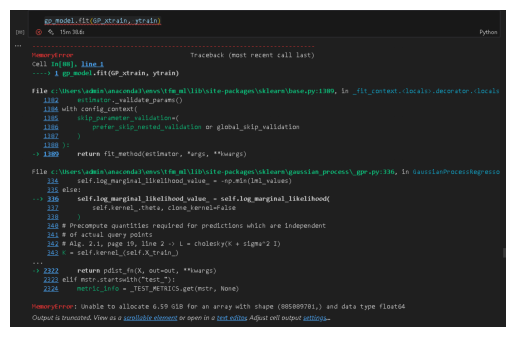

In [97]:
gp_model_error = mpimg.imread('gp_model_error.png')
plt.imshow(gp_model_error)
plt.axis('off')
plt.show()

Reduced models using only values where the zbmi score at 14 is real and not interpolated

LSTM

In [89]:
reduced_LSTM_xtrain = lstm_preprocess(reduced_xtrain, LSTM_measure_cols, ["sex_Female", "sex_Male"], "stratify")
reduced_LSTM_xtest = lstm_preprocess(reduced_xtest, LSTM_measure_cols, ["sex_Female", "sex_Male"], "stratify")

In [163]:
reduced_lstm_xtrain = np.nan_to_num(reduced_LSTM_xtrain, nan=999.0)
reduced_lstm_xtest = np.nan_to_num(reduced_LSTM_xtest, nan=999.0)

In [ ]:
reduced_lstm_model = tf.keras.models.Sequential()
reduced_lstm_model.add(tf.keras.layers.Input(shape=(12, 4)))
reduced_lstm_model.add(tf.keras.layers.Masking(mask_value=999.0))
reduced_lstm_model.add(tf.keras.layers.LSTM(64))
reduced_lstm_model.add(tf.keras.layers.Dense(1, activation='linear'))
reduced_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [156]:
Reduced_lstm_model = reduced_lstm_model.fit(reduced_lstm_xtrain, reduced_ytrain, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20
130/130 [==============================] - 10s 27ms/step - loss: 1.1024 - mae: 0.8252 - val_loss: 0.6479 - val_mae: 0.6243
Epoch 2/20
130/130 [==============================] - 1s 8ms/step - loss: 0.5409 - mae: 0.5643 - val_loss: 0.4482 - val_mae: 0.5185
Epoch 3/20
130/130 [==============================] - 1s 7ms/step - loss: 0.4148 - mae: 0.4927 - val_loss: 0.3866 - val_mae: 0.4773
Epoch 4/20
130/130 [==============================] - 1s 8ms/step - loss: 0.3861 - mae: 0.4766 - val_loss: 0.3655 - val_mae: 0.4602
Epoch 5/20
130/130 [==============================] - 1s 9ms/step - loss: 0.3769 - mae: 0.4706 - val_loss: 0.3642 - val_mae: 0.4592
Epoch 6/20
130/130 [==============================] - 1s 8ms/step - loss: 0.3709 - mae: 0.4659 - val_loss: 0.3631 - val_mae: 0.4562
Epoch 7/20
130/130 [==============================] - 1s 9ms/step - loss: 0.3789 - mae: 0.4708 - val_loss: 0.3680 - val_mae: 0.4685
Epoch 8/20
130/130 [==============================] - 1s 8ms/step - loss: 

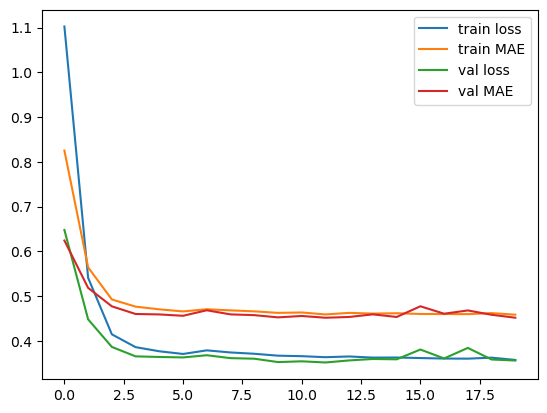

In [157]:
plt.plot(Reduced_lstm_model.history['loss'], label='train loss')
plt.plot(Reduced_lstm_model.history['mae'], label='train MAE')
plt.plot(Reduced_lstm_model.history['val_loss'], label='val loss')
plt.plot(Reduced_lstm_model.history['val_mae'], label='val MAE')
plt.legend()
plt.show()

GRU

In [158]:
reduced_gru_model = tf.keras.models.Sequential()
reduced_gru_model.add(tf.keras.layers.Input(shape=(12, 4)))
reduced_gru_model.add(tf.keras.layers.Masking(mask_value=999.0))
reduced_gru_model.add(tf.keras.layers.GRU(64))
reduced_gru_model.add(tf.keras.layers.Dense(1, activation='linear'))
reduced_gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [159]:
reduced_GRU_model = reduced_gru_model.fit(reduced_lstm_xtrain, reduced_ytrain, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20
130/130 [==============================] - 11s 34ms/step - loss: 0.7027 - mae: 0.6368 - val_loss: 0.4000 - val_mae: 0.4884
Epoch 2/20
130/130 [==============================] - 2s 12ms/step - loss: 0.3925 - mae: 0.4809 - val_loss: 0.3800 - val_mae: 0.4764
Epoch 3/20
130/130 [==============================] - 1s 8ms/step - loss: 0.3746 - mae: 0.4700 - val_loss: 0.3771 - val_mae: 0.4727
Epoch 4/20
130/130 [==============================] - 1s 9ms/step - loss: 0.3791 - mae: 0.4712 - val_loss: 0.3643 - val_mae: 0.4571
Epoch 5/20
130/130 [==============================] - 1s 8ms/step - loss: 0.3711 - mae: 0.4660 - val_loss: 0.3597 - val_mae: 0.4571
Epoch 6/20
130/130 [==============================] - 1s 8ms/step - loss: 0.3701 - mae: 0.4664 - val_loss: 0.3532 - val_mae: 0.4522
Epoch 7/20
130/130 [==============================] - 1s 8ms/step - loss: 0.3689 - mae: 0.4659 - val_loss: 0.3592 - val_mae: 0.4575
Epoch 8/20
130/130 [==============================] - 1s 8ms/step - loss:

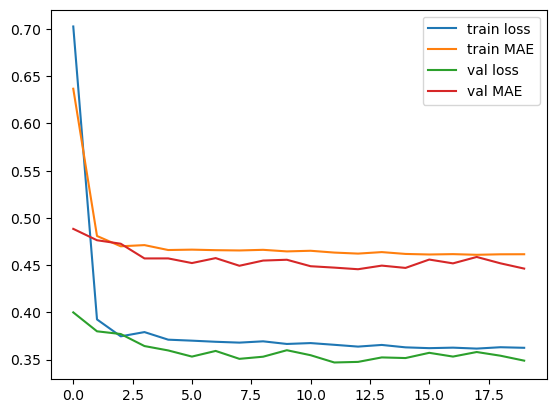

In [161]:
plt.plot(reduced_GRU_model.history['loss'], label='train loss')
plt.plot(reduced_GRU_model.history['mae'], label='train MAE')
plt.plot(reduced_GRU_model.history['val_loss'], label='val loss')
plt.plot(reduced_GRU_model.history['val_mae'], label='val MAE')
plt.legend()
plt.show()

In [104]:
reduced_gru_loss, reduced_gru_accuracy = reduced_gru_model.evaluate(reduced_lstm_xtest, reduced_ytest)

80/80 [==============================] - 1s 7ms/step - loss: 0.3711 - mae: 0.4753


Random forest

In [76]:
reduced_RF_xtrain = reduced_xtrain[cols_for_RF].copy()
reduced_RF_xtest = reduced_xtest[cols_for_RF].copy()
reduced_RF_xtrain.loc[:, "stratify"] = reduced_RF_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
reduced_RF_xtest.loc[:, "stratify"] = reduced_RF_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

reduced_RF_xtrain["stratify"] = reduced_RF_xtrain["stratify"].astype(float)
reduced_RF_xtest["stratify"] = reduced_RF_xtest["stratify"].astype(float)
def process_cols_RF(df):
    df = df.copy()
    for i in range(2, 14, 1):
        zbmi_col = "zbmi_" + str(i)
        missing_col = "missing_zbmi_" + str(i)
        df.loc[:, missing_col] = df[zbmi_col].apply(lambda x: 1 if pd.isna(x) else 0)
        df.loc[:, zbmi_col] = df[zbmi_col].fillna(999.0)

    return df
reduced_RF_xtrain = process_cols_RF(reduced_RF_xtrain)
reduced_RF_xtest = process_cols_RF(reduced_RF_xtest)

In [77]:
reduced_RF_model = sk.ensemble.RandomForestRegressor(
    n_estimators = 100,
    max_depth = None,
    random_state = 42,
    n_jobs = -1)
reduced_RF_model.fit(reduced_RF_xtrain, reduced_ytrain)

RandomForestRegressor(n_jobs=-1, random_state=42)

XGBOOST

In [78]:
reduced_XGBoost_xtrain = reduced_xtrain[cols_for_XGBoost].copy()
reduced_XGBoost_xtest = reduced_xtest[cols_for_XGBoost].copy()

reduced_XGBoost_xtrain.loc[:, "stratify"] = reduced_XGBoost_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
reduced_XGBoost_xtest.loc[:, "stratify"] = reduced_XGBoost_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

reduced_XGBoost_xtrain["stratify"] = reduced_XGBoost_xtrain["stratify"].astype(float)
reduced_XGBoost_xtest["stratify"] = reduced_XGBoost_xtest["stratify"].astype(float)

In [79]:
reduced_XGB_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    missing=np.nan,
    random_state=42
)
reduced_XGB_model.fit(reduced_XGBoost_xtrain, reduced_ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

HMM

In [80]:
reduced_HMM_xtrain = reduced_xtrain[cols_for_HMM].copy()
reduced_HMM_xtest = reduced_xtest[cols_for_HMM].copy()

reduced_HMM_xtrain.loc[:, "stratify"] = reduced_HMM_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
reduced_HMM_xtest.loc[:, "stratify"] = reduced_HMM_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

reduced_HMM_xtrain["stratify"] = reduced_HMM_xtrain["stratify"].astype(float)
reduced_HMM_xtest["stratify"] = reduced_HMM_xtest["stratify"].astype(float)
reduced_HMM_xtrain = hmm_preprocess(reduced_HMM_xtrain, cols_for_HMM)
reduced_HMM_xtest = hmm_preprocess(reduced_HMM_xtest, cols_for_HMM)

In [140]:
reduced_HMM_model = GaussianHMM(n_components=4, covariance_type="full", n_iter=1000)
reduced_HMM_model.fit(reduced_HMM_xtrain)

Model is not converging.  Current: 79957.43363650654 is not greater than 83442.52306949867. Delta is -3485.0894329921284


GaussianHMM(covariance_type='full', n_components=4, n_iter=1000)

GP

In [91]:
reduced_GP_xtrain = reduced_xtrain[cols_for_GP].copy()
reduced_GP_xtest = reduced_xtest[cols_for_GP].copy()

reduced_GP_xtrain.loc[:, "stratify"] = reduced_GP_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
reduced_GP_xtest.loc[:, "stratify"] = reduced_GP_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

reduced_GP_xtrain["stratify"] = reduced_GP_xtrain["stratify"].astype(float)
reduced_GP_xtest["stratify"] = reduced_GP_xtest["stratify"].astype(float)
reduced_GP_xtrain = gp_preprocess(reduced_GP_xtrain)
reduced_GP_xtest = gp_preprocess(reduced_GP_xtest)

In [92]:
reduced_gp_model = sk.gaussian_process.GaussianProcessRegressor()

In [93]:
reduced_gp_model.fit(reduced_GP_xtrain, reduced_ytrain)

GaussianProcessRegressor()

Predictions and model evaluation

In [94]:
LSTM_loss, LSTM_accuracy = lstm_model.evaluate(LSTM_xtest, ytest)

648/648 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00


In [105]:
LSTM_preds = lstm_model.predict(LSTM_xtest)

648/648 [==============================] - 5s 4ms/step


In [149]:
Seq_LSTM_preds = Seq_lstm_model.predict(Seq_lstm_xtest)

648/648 [==============================] - 2s 3ms/step


In [107]:
GRU_preds = gru_model.predict(GRU_xtest)

648/648 [==============================] - 9s 3ms/step


In [108]:
RF_preds = RF_model.predict(RF_xtest)

In [109]:
XGB_preds = XGB_model.predict(XGBoost_xtest)

In [141]:
HMM_preds = HMM_model.predict(HMM_xtest)

In [164]:
Red_LSTM_preds = reduced_lstm_model.predict(reduced_lstm_xtest)

80/80 [==============================] - 2s 3ms/step


In [165]:
Red_GRU_preds = reduced_gru_model.predict(reduced_lstm_xtest)

80/80 [==============================] - 2s 3ms/step


In [113]:
Red_RF_preds = reduced_RF_model.predict(reduced_RF_xtest)

In [114]:
Red_XGB_preds = reduced_XGB_model.predict(reduced_XGBoost_xtest)

In [142]:
Red_HMM_preds = reduced_HMM_model.predict(reduced_HMM_xtest)

In [116]:
Red_GP_preds = reduced_gp_model.predict(reduced_GP_xtest)

We will convert our ytest into labels and proceed to do the same with our predictions

In [120]:
# Define a converter function
def convert_to_label(predictions):
    labels = []
    for prediction in predictions:
        match prediction:
            case _ if prediction < -2.0:
                labels.append("Underweight")
            case _ if -2.0 <= prediction <= 1.0:
                labels.append("Normal_weight")
            case _ if 1.0 < prediction <= 2.0:
                labels.append("Overweight")
            case _ if prediction > 2.0:
                labels.append("Obese")
            case _:
                labels.append(np.nan)
    
    return labels

In [126]:
labels_ytest = convert_to_label(ytest)
labels_Red_ytest = convert_to_label(reduced_ytest)
labels_ytest[0:5]

['Obese', 'Normal_weight', 'Normal_weight', 'Obese', 'Overweight']

In [166]:
full_model_outputs = {
    "labels_LSTM_preds": convert_to_label(LSTM_preds),
    "labels_Seq_LSTM_preds": convert_to_label(Seq_LSTM_preds),
    "labels_GRU_preds": convert_to_label(GRU_preds),
    "labels_RF_preds": convert_to_label(RF_preds),
    "labels_XGB_preds": convert_to_label(XGB_preds),
    "labels_HMM_preds": convert_to_label(HMM_preds)
}

reduced_model_outputs = { 
    "labels_Red_LSTM_preds": convert_to_label(Red_LSTM_preds),
    "labels_Red_GRU_preds": convert_to_label(Red_GRU_preds),
    "labels_Red_RF_preds": convert_to_label(Red_RF_preds),
    "labels_Red_XGB_preds": convert_to_label(Red_XGB_preds),
    "labels_Red_HMM_preds": convert_to_label(Red_HMM_preds),
    "labels_Red_GP_preds": convert_to_label(Red_GP_preds)
}

In [152]:
for model, output in full_model_outputs.items():
    print(f"Model: {model}")
    print(classification_report(labels_ytest, output), flush= True)

Model: labels_LSTM_preds
               precision    recall  f1-score   support

Normal_weight       0.64      1.00      0.78     13185
        Obese       0.00      0.00      0.00      2905
   Overweight       0.00      0.00      0.00      4222
  Underweight       0.00      0.00      0.00       412

     accuracy                           0.64     20724
    macro avg       0.16      0.25      0.19     20724
 weighted avg       0.40      0.64      0.49     20724



c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: labels_Seq_LSTM_preds
               precision    recall  f1-score   support

Normal_weight       0.98      0.98      0.98     13185
        Obese       0.97      0.95      0.96      2905
   Overweight       0.93      0.93      0.93      4222
  Underweight       0.94      0.91      0.92       412

     accuracy                           0.97     20724
    macro avg       0.95      0.94      0.95     20724
 weighted avg       0.97      0.97      0.97     20724

Model: labels_GRU_preds
               precision    recall  f1-score   support

Normal_weight       0.98      0.98      0.98     13185
        Obese       0.96      0.95      0.96      2905
   Overweight       0.91      0.93      0.92      4222
  Underweight       0.94      0.90      0.92       412

     accuracy                           0.96     20724
    macro avg       0.95      0.94      0.95     20724
 weighted avg       0.96      0.96      0.96     20724

Model: labels_RF_preds
               precision    recall  f1

c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [167]:
for model, output in reduced_model_outputs.items():
    print(f"Model: {model}")
    print(classification_report(labels_Red_ytest, output))

Model: labels_Red_LSTM_preds
               precision    recall  f1-score   support

Normal_weight       0.88      0.89      0.89      1633
        Obese       0.74      0.64      0.69       307
   Overweight       0.57      0.62      0.60       553
  Underweight       0.76      0.29      0.42        55

     accuracy                           0.79      2548
    macro avg       0.74      0.61      0.65      2548
 weighted avg       0.80      0.79      0.79      2548

Model: labels_Red_GRU_preds
               precision    recall  f1-score   support

Normal_weight       0.88      0.90      0.89      1633
        Obese       0.76      0.61      0.68       307
   Overweight       0.57      0.63      0.60       553
  Underweight       0.77      0.31      0.44        55

     accuracy                           0.79      2548
    macro avg       0.75      0.61      0.65      2548
 weighted avg       0.80      0.79      0.79      2548

Model: labels_Red_RF_preds
               precision    re

c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
